<h3><center>Corporate Burnout Regression</center></h3>   

    
<center>Sam Loyd</center>
<center>June 2021</center> 

In [1]:
# Required Modules
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import *
from imblearn.combine import SMOTETomek
from collections import Counter
from pycaret.regression import *
from sklearn import metrics
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data Analysis - EDA

In [2]:
# Pull in data for stroke data 
train_df = pd.read_csv("data\\train.csv")
# test_df = pd.read_csv("data\\test.csv")

In [3]:
# Setup frame
# frames = [train_df, test_df]

In [4]:
# Join them
# burnout_df = pd.concat(frames)

# Test data has no target variables
burnout_df = train_df

In [5]:
# First look
burnout_df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.00000,3.00000,3.80000,0.16000
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.00000,2.00000,5.00000,0.36000
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.00000,nan,5.80000,0.49000
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.00000,1.00000,2.60000,0.20000
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.00000,7.00000,6.90000,0.52000


In [6]:
burnout_df.dtypes

Employee ID              object
Date of Joining          object
Gender                   object
Company Type             object
WFH Setup Available      object
Designation             float64
Resource Allocation     float64
Mental Fatigue Score    float64
Burn Rate               float64
dtype: object

In [7]:
burnout_df['Julian Date'] = pd.DatetimeIndex(burnout_df['Date of Joining']).to_julian_date()
burnout_df['Date of Joining'] =  pd.to_datetime(burnout_df['Date of Joining'], infer_datetime_format=True)

In [8]:
# Apply profie and create html report
# Commented out for performance
# prof = ProfileReport(burnout_df,title="Pandas Profiling Report - Burnout Data", explorative=True)
# prof.to_file(output_file='burnout-pandas-profile-report.html')

# Please see stroke-pandas-profile-report.html for a full analysis 

### [Pandas report](https://sdloyd.github.io/Stroke/pandasprofile/stroke-pandas-profile-report.html)

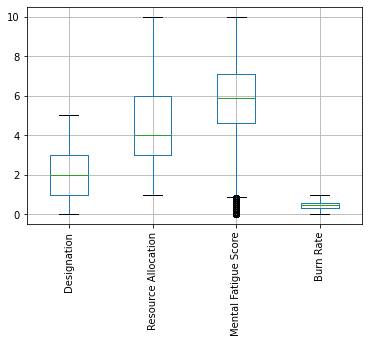

In [9]:
# Pandas-profiling is lacking in outlier analysis visuals so those are included here.
# Only mental fatigue score shows outliers

# Box and whisker plots for outlier analysis.
boxplot = burnout_df.boxplot(column=['Designation','Resource Allocation','Mental Fatigue Score','Burn Rate'],rot=90)


## Data Wrangling  
Impute missing values found in the EDA process using pandas-profile report and remove rows missing target variable.

In [10]:
# Take a look - saw no significant reason to standardize or normalize based on the max values
burnout_df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Julian Date
count,22750.00000,21369.00000,20633.00000,21626.00000,22750.00000
mean,2.17873,4.48140,5.72819,0.45201,2454648.89451
std,1.13514,2.04721,1.92084,0.19823,105.34819
min,0.00000,1.00000,0.00000,0.00000,2454466.50000
25%,1.00000,3.00000,4.60000,0.31000,2454557.50000
50%,2.00000,4.00000,5.90000,0.45000,2454649.50000
75%,3.00000,6.00000,7.10000,0.59000,2454739.50000
max,5.00000,10.00000,10.00000,1.00000,2454831.50000


In [11]:
# Gather mins
min_df = pd.to_datetime(burnout_df['Date of Joining'].min())

In [12]:
# Look at data types
burnout_df.dtypes

Employee ID                     object
Date of Joining         datetime64[ns]
Gender                          object
Company Type                    object
WFH Setup Available             object
Designation                    float64
Resource Allocation            float64
Mental Fatigue Score           float64
Burn Rate                      float64
Julian Date                    float64
dtype: object

In [13]:
# Convert outlier to min value
burnout_df["Mental Fatigue Score"]=np.where(burnout_df["Mental Fatigue Score"] < 1, 1, burnout_df["Mental Fatigue Score"])


In [14]:
burnout_df["Mental Fatigue Score"]

0       3.80000
1       5.00000
2       5.80000
3       2.60000
4       6.90000
          ...  
22745       nan
22746   6.70000
22747       nan
22748   5.90000
22749   7.80000
Name: Mental Fatigue Score, Length: 22750, dtype: float64

In [15]:
# Didn't help model
# Determine how long relative to others
# burnout_df['Relative Tenure'] = (burnout_df['Date of Joining'] - min_df).dt.days

In [16]:
burnout_df

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Julian Date
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.00000,3.00000,3.80000,0.16000,2454739.50000
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.00000,2.00000,5.00000,0.36000,2454800.50000
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.00000,nan,5.80000,0.49000,2454535.50000
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.00000,1.00000,2.60000,0.20000,2454773.50000
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.00000,7.00000,6.90000,0.52000,2454671.50000
...,...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,1.00000,3.00000,nan,0.41000,2454830.50000
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,3.00000,6.00000,6.70000,0.59000,2454484.50000
22747,fffe390032003000,2008-11-05,Male,Service,Yes,3.00000,7.00000,nan,0.72000,2454775.50000
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,2.00000,5.00000,5.90000,0.52000,2454475.50000


In [17]:
# Count nulls
burnout_df.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
Julian Date                0
dtype: int64

In [18]:
# Since burnrate is the target removing any rows missing burnrate
burnout_df.dropna(subset=['Burn Rate'], inplace=True)

In [19]:
# Separate target variable before imputation to avoid future data concerns
knn_df = burnout_df.drop(['Burn Rate'], axis=1)

In [20]:
# Impute with K nearest
impute = KNNImputer(n_neighbors = 6, weights = 'uniform')
knn_df['Resource Allocation'] = impute.fit_transform(knn_df[['Resource Allocation']])
knn_df['Mental Fatigue Score'] = impute.fit_transform(knn_df[['Mental Fatigue Score']])

In [21]:
# New Frame
clean_burnout_df = knn_df

In [22]:
# Add target back
clean_burnout_df['Burn Rate'] = burnout_df['Burn Rate']

In [23]:
# Given ranges scale values
sc = MinMaxScaler()
cols = ['Designation','Resource Allocation','Mental Fatigue Score','Julian Date']
clean_burnout_df[cols] = sc.fit_transform(clean_burnout_df[cols])

In [24]:
# First look
clean_burnout_df

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Julian Date,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,0.40000,0.22222,0.31111,0.74795,0.16000
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,0.20000,0.11111,0.44444,0.91507,0.36000
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,0.40000,0.38709,0.53333,0.18904,0.49000
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,0.20000,0.00000,0.17778,0.84110,0.20000
4,fffe31003900340031003600,2008-07-24,Female,Service,No,0.60000,0.66667,0.65556,0.56164,0.52000
...,...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,0.20000,0.22222,0.52695,0.99726,0.41000
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,0.60000,0.55556,0.63333,0.04932,0.59000
22747,fffe390032003000,2008-11-05,Male,Service,Yes,0.60000,0.66667,0.52695,0.84658,0.72000
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,0.40000,0.44444,0.54444,0.02466,0.52000


In [25]:
# Count nulls
clean_burnout_df.isnull().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Julian Date             0
Burn Rate               0
dtype: int64

In [26]:
# Binary values
# 1 unknown, but I made it female since it was the most common
clean_burnout_df['Gender'] = np.where(clean_burnout_df['Gender']=='Male', 1, 0)
clean_burnout_df['Company Type'] = np.where(clean_burnout_df['Company Type']=='Product', 1, 0)
clean_burnout_df['WFH Setup Available'] = np.where(clean_burnout_df['WFH Setup Available']=='True', 1, 0)

In [27]:
# Any impact on stats - looks acceptable 
clean_burnout_df.describe()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Julian Date,Burn Rate
count,21626.00000,21626.00000,21626.00000,21626.00000,21626.00000,21626.00000,21626.00000,21626.00000
mean,0.47522,0.34690,0.00000,0.43575,0.38709,0.52695,0.49962,0.45201
std,0.49940,0.47599,0.00000,0.22709,0.22075,0.19995,0.28872,0.19823
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.20000,0.22222,0.41111,0.24658,0.31000
50%,0.00000,0.00000,0.00000,0.40000,0.38709,0.52695,0.50137,0.45000
75%,1.00000,1.00000,0.00000,0.60000,0.55556,0.65556,0.74795,0.59000
max,1.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [28]:
clean_burnout_df

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Julian Date,Burn Rate
0,fffe32003000360033003200,2008-09-30,0,0,0,0.40000,0.22222,0.31111,0.74795,0.16000
1,fffe3700360033003500,2008-11-30,1,0,0,0.20000,0.11111,0.44444,0.91507,0.36000
2,fffe31003300320037003900,2008-03-10,0,1,0,0.40000,0.38709,0.53333,0.18904,0.49000
3,fffe32003400380032003900,2008-11-03,1,0,0,0.20000,0.00000,0.17778,0.84110,0.20000
4,fffe31003900340031003600,2008-07-24,0,0,0,0.60000,0.66667,0.65556,0.56164,0.52000
...,...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,0,0,0,0.20000,0.22222,0.52695,0.99726,0.41000
22746,fffe33003000350031003800,2008-01-19,0,1,0,0.60000,0.55556,0.63333,0.04932,0.59000
22747,fffe390032003000,2008-11-05,1,0,0,0.60000,0.66667,0.52695,0.84658,0.72000
22748,fffe33003300320036003900,2008-01-10,0,0,0,0.40000,0.44444,0.54444,0.02466,0.52000


In [29]:
# No need to pass to model, just an ID
model_burnout_df = clean_burnout_df.drop(['Employee ID','Date of Joining','Mental Fatigue Score'], axis=1)

In [30]:
# Split the validation and train data - Pycaret will split out the test
# Create X from the features
X = model_burnout_df.drop(columns=['Burn Rate'])

# Create y from output
y = model_burnout_df[['Burn Rate']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.40, random_state=1)

In [31]:
# PyCaret requires them in one dataframe
X_train_caret_reg = X_train.copy()
X_train_caret_reg['Burn Rate'] = y_train['Burn Rate']
X_train_caret_reg

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Julian Date,Burn Rate
11215,0,0,0,0.60000,0.44444,0.27397,0.59000
4585,0,0,0,0.80000,0.66667,0.67671,0.88000
21893,0,0,0,0.60000,0.55556,0.12603,0.55000
21891,0,0,0,0.60000,0.44444,0.56986,0.28000
13160,0,0,0,0.20000,0.00000,0.24384,0.26000
...,...,...,...,...,...,...,...
11507,0,0,0,0.40000,0.55556,0.16986,0.58000
18190,0,0,0,0.60000,0.33333,0.47397,0.39000
5434,0,0,0,0.60000,0.44444,0.79178,0.24000
12790,1,1,0,0.00000,0.00000,0.58356,0.18000


In [32]:
# Prepare model
exp_clf_reg = setup(X_train_caret_reg, target='Burn Rate', silent=True)

,Description,Value
0,session_id,738
1,Target,Burn Rate
2,Original Data,"(12975, 7)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(9082, 6)"


In [33]:
# Compare the model
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0833,0.0107,0.1033,0.7303,0.0732,0.2903,0.1340
lightgbm,Light Gradient Boosting Machine,0.0840,0.0109,0.1043,0.7250,0.0738,0.2899,0.2680
catboost,CatBoost Regressor,0.0841,0.0109,0.1044,0.7245,0.0739,0.2894,1.2790
ada,AdaBoost Regressor,0.0876,0.0116,0.1079,0.7055,0.0762,0.3005,0.0630
xgboost,Extreme Gradient Boosting,0.0873,0.0118,0.1087,0.7012,0.0769,0.2990,0.5840
ridge,Ridge Regression,0.0876,0.0119,0.1092,0.6984,0.0773,0.3102,0.0080
lar,Least Angle Regression,0.0876,0.0119,0.1092,0.6984,0.0773,0.3099,0.0080
br,Bayesian Ridge,0.0876,0.0119,0.1092,0.6984,0.0773,0.3099,0.0100
lr,Linear Regression,0.0876,0.0119,0.1092,0.6984,0.0773,0.3099,0.6770
huber,Huber Regressor,0.0874,0.0120,0.1094,0.6974,0.0774,0.3102,0.0160


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=738, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
# Model selected - catboost 
model_pick = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0861,0.0112,0.1060,0.7091,0.0741,0.2352
1,0.0838,0.0106,0.1027,0.7181,0.0718,0.2546
2,0.0847,0.0109,0.1046,0.7496,0.0744,0.3124
3,0.0854,0.0112,0.1057,0.7022,0.0754,0.2959
4,0.0821,0.0105,0.1027,0.7646,0.0731,0.3242
5,0.0816,0.0103,0.1016,0.7309,0.0721,0.2821
6,0.0788,0.0096,0.0979,0.7442,0.0690,0.2836
7,0.0798,0.0099,0.0995,0.7645,0.0702,0.3060
8,0.0834,0.0109,0.1045,0.7275,0.0745,0.3086
9,0.0872,0.0116,0.1077,0.6928,0.0772,0.3004


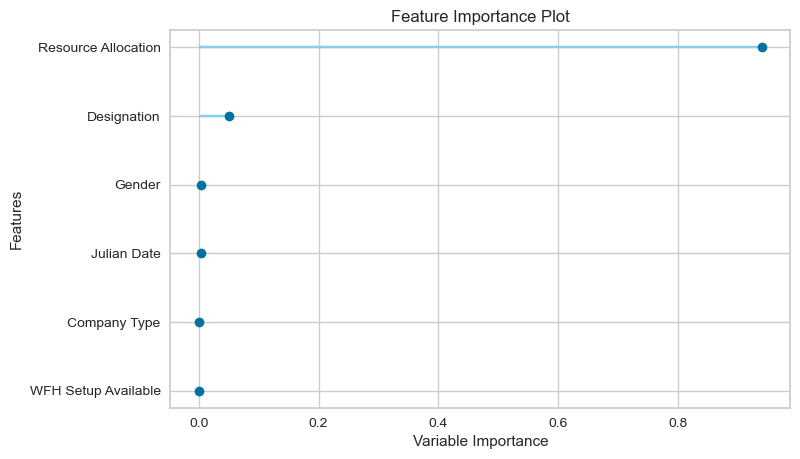

In [35]:
# Lets look at them - Note pycaret took care of the encoding on date 
plot_model(model_pick, plot='feature')

In [36]:
# Tuning
tuned_model_pick = tune_model(model_pick)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0883,0.0119,0.1090,0.6923,0.0762,0.2396
1,0.0856,0.0111,0.1054,0.7032,0.0737,0.2637
2,0.0860,0.0113,0.1063,0.7414,0.0755,0.3199
3,0.0873,0.0118,0.1085,0.6860,0.0773,0.3024
4,0.0844,0.0113,0.1062,0.7479,0.0751,0.3256
5,0.0821,0.0107,0.1033,0.7216,0.0732,0.2790
6,0.0798,0.0098,0.0989,0.7387,0.0696,0.2845
7,0.0804,0.0101,0.1004,0.7604,0.0711,0.3098
8,0.0835,0.0110,0.1049,0.7256,0.0747,0.3024
9,0.0884,0.0119,0.1089,0.6860,0.0780,0.3052


In [37]:
# Finalize the model
final_model = finalize_model(tuned_model_pick)

In [38]:
# predict validation data
val_predictions = predict_model(final_model, data=X_val)
val_predictions.Label

10357   0.12204
9443    0.57181
20516   0.41188
8902    0.35744
12396   0.28172
          ...  
22657   0.49198
14423   0.34676
5167    0.66408
19732   0.67107
19714   0.45056
Name: Label, Length: 8651, dtype: float64

In [39]:
# Validation Stats
mae = metrics.mean_absolute_error(y_val, val_predictions.Label)
mse = metrics.mean_squared_error(y_val, val_predictions.Label)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(y_val, val_predictions.Label)

print("Results:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results:
MAE: 0.08428663757685048
MSE: 0.011157690981975284
RMSE: 0.10562997198700416
R-Squared: 0.7138034951897774


In [40]:
# Save the model as a pickle file
filename = 'pickle/burnout_secondary_model.pickle'
pickle.dump(final_model, open(filename, 'wb'))

In [41]:
# Save model in pycaret format
save_model(final_model, 'model/burnout_secondary_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Burn Rate',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                                            learning_rate=0.261, loss='ls',
                                            max_depth=2, max_features='log2',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0001,
                   